##Loading the Dataset

In [1]:
!pip install kaggle

In [2]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"mukulsaluja","key":"dcb0ebb075e5e18bdeda9eaf99737f2f"}'}

In [3]:
#after the uploading run this cell
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

amazon-fine-food-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [46]:
from zipfile import ZipFile
file_name="amazon-fine-food-reviews.zip" #name of the file you downloaded

with ZipFile(file_name,'r') as z:
  print("Extracting the file {}".format(file_name))
  z.extractall()
  print("Done Extracting")

Extracting the file amazon-fine-food-reviews.zip
Done Extracting


In [6]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download("stopwords")
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
connection=sqlite3.connect("/content/database.sqlite")
data=pd.read_sql_query("""
Select *
from Reviews
where score!=3
""",connection)

In [8]:
def partition(x):
  if x<3:
    return 0
  else:
    return 1

In [9]:
actual_score=data["Score"]
label=actual_score.map(partition)
data["Score"]=label
print("In our Dataset we have {0} rows and {1} columns".format(data.shape[0],data.shape[1]))

In our Dataset we have 525814 rows and 10 columns


In [10]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [11]:
sample_data = data.head(100000)

#Data cleaning and eda


It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", connection)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [13]:
sort_data=sample_data.sort_values(by="ProductId",ascending=True)
final=sort_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first",inplace=False)

In [14]:
print("Before doing Deduplication or removing duplicate rows we have {} rows".format(sort_data.shape[0]))
print("After doing Deduplication or removing duplicate rows we have {} rows".format(final.shape[0]))
print("Percentage of data still remain same is {} %".format((final['Id'].size*1.0)/(sort_data['Id'].size*1.0)*100))

Before doing Deduplication or removing duplicate rows we have 100000 rows
After doing Deduplication or removing duplicate rows we have 87775 rows
Percentage of data still remain same is 87.775 %


####In the data It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [15]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", connection)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [16]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
print(final.shape)

(87773, 10)


In [17]:
final["Score"].value_counts()

1    73592
0    14181
Name: Score, dtype: int64

## Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [18]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

4
I wish I'd read the reviews before making this purchase. It's basically a cardsotck box that is sticky all over the OUTSIDE. Those pink-ish things that look like entrances "into" the trap? They're just pictures. There *is no* inside of the trap. All the flies will be stuck to the OUTSIDE. It's basically fly paper, just horribly, horribly HORRIBLY overpriced.<br /><br />Do yourself a favor and just get fly paper or fly strips. Same yuck factor, but much cheaper.


In [19]:
stop=set(stopwords.words('english')) #this conatin the set /unique stop words
sno=nltk.stem.SnowballStemmer('english') #initializing the object for snowball stemmer

def clean_html(sentence): #this is the function to remove the tags of html
  cleanr=re.compile('<.*?>')
  clean_text=re.sub(cleanr,"",sentence)
  return clean_text

def clean_punc(sentence):#remove punctuations marks
  cleaned=re.sub(r'[?|!|\'|"|#]',r'',sentence)
  cleaned=re.sub(r'[.|,|)|(|\|/]',r'',cleaned)
  return cleaned

In [20]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase

if not os.path.isfile('final.sqlite'):
  final_string=[] 
  positive_words=[] # it store all the words that we get from postive reviews
  negative_words=[] # it store all the words that we get from negative reviews
  
  for i , sent in enumerate(tqdm(final['Text'].values)):
    filter_sentences=[]
    sent=clean_html(sent)#to remove html tags

    for w in sent.split():#split using space to remove marks
      for clean_words in clean_punc(w).split():#like abc,def then after removing puntuation we get abc def do we again do split
        if((clean_words.isalpha())& (len(clean_words)>2)):
          if(clean_words.islower() not in stop):#check that the word is not in stop word
            s=(sno.stem(clean_words.lower())).encode('utf8')#doing stemming using snowball stemmmer
            filter_sentences.append(s)#adding the words to make a list

            if(final['Score'].values)[i]==1:
              positive_words.append(s)#adding positive words in postive list
            if(final['Score'].values)[i]==0:
              negative_words.append(s)#adding negtive words in negative list
    str_new=b" ".join(filter_sentences)#joining the words that are in list of filter to make a complete sentence and then appending it into final_string list
    final_string.append(str_new)

100%|██████████| 87773/87773 [02:36<00:00, 561.78it/s]


In [22]:
    #storing the data into .sqlite file
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
              index=True, index_label=None, chunksize=None, dtype=None)
conn.close()
    
#saving the list of postive and negtive words for future use    
with open('positive_words.pkl', 'wb') as f:
  pickle.dump(positive_words, f)   
with open('negitive_words.pkl', 'wb') as f:
  pickle.dump(negative_words, f)    

In [23]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [24]:
#sorting data based on time
final_reviews = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final_reviews.shape

(87773, 12)

#Splitting the datasets into two parts

In [26]:
from sklearn.model_selection import train_test_split
X = final_reviews['CleanedText']
Y = final_reviews['Score']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.33, random_state=0)
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size=.33, random_state=0)
print('X_train, Y_train', X_train.shape, Y_train.shape)
print('X_test, Y_test', X_test.shape, Y_test.shape)
print('X_tr, Y_tr', X_tr.shape, Y_tr.shape)
print('X_cv, Y_cv', X_cv.shape, Y_cv.shape)

X_train, Y_train (58807,) (58807,)
X_test, Y_test (28966,) (28966,)
X_tr, Y_tr (39400,) (39400,)
X_cv, Y_cv (19407,) (19407,)


In [27]:
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [28]:
from sklearn.ensemble import RandomForestClassifier
# Random forest classifier
def RF_Classifier(X_train,X_cv,Y_train,Y_cv):
    pred_cv = []
    pred_train = []
    depths = [2, 3, 5, 8, 10, 20]
    estimators = [100, 200, 300, 400, 500]
    for i in depths:
        for j in estimators:
            clf = RandomForestClassifier(n_estimators=j, max_depth=i, n_jobs = -1, class_weight='balanced')
            clf.fit(X_train,Y_train)
            probs = clf.predict_proba(X_cv)
            prob = clf.predict_proba(X_train)
            probs = probs[:,1]
            prob = prob[:,1]
            auc_score_cv = roc_auc_score(Y_cv,probs)
            auc_score_train = roc_auc_score(Y_train,prob)
            pred_cv.append(auc_score_cv)
            pred_train.append(auc_score_train)
    cmap=sns.light_palette("green")
    # representing heat map for auc score
    print("-"*30, "AUC Score for train data", "-"*30)
    pred_train = np.array(pred_train)
    pred_train = pred_train.reshape(len(depths),len(estimators))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_train,annot=True, cmap=cmap, fmt=".3f", xticklabels=estimators,yticklabels=depths)
    plt.xlabel('Estimators')
    plt.ylabel('Depths')
    plt.show()
    print("-"*30, "AUC Score for CV data", "-"*30)
    pred_cv = np.array(pred_cv)
    pred_cv = pred_cv.reshape(len(depths),len(estimators))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_cv, annot=True, cmap=cmap, fmt=".3f", xticklabels=estimators, yticklabels=depths)
    plt.xlabel('Estimators')
    plt.ylabel('Depths')
    plt.show()    

## Testing Model on Training data and Test data for Random Forest

In [43]:
import sklearn.metrics as skplt
def testing(X_train,Y_train,X_test,Y_test,optimal_depth,optimal_estimator):
    clf = RandomForestClassifier(n_estimators = optimal_estimator, max_depth = optimal_depth,class_weight='balanced')
    clf.fit(X_train,Y_train)
    prob = clf.predict_proba(X_test) 
    prob1 = clf.predict_proba(X_train)
    # keep probabilities for the positive outcome only
    probs = prob[:, 1]
    probs1 = prob1[:,1]
    print("AUC Score for train data",roc_auc_score(Y_train,probs1))
    print("AUC Score for test data",roc_auc_score(Y_test,probs))
    # calculate roc curve
    fpr_train, tpr_train, thresholds = roc_curve(Y_train,probs1)
    fpr_test, tpr_test, thresholds = roc_curve(Y_test,probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr_test, tpr_test, marker='.',color ='b',label='Test Data')
    plt.plot(fpr_train, tpr_train, marker='.',color= 'r',label='Train Data')
    plt.title("Line Plot of ROC Curve on Train Data and Test Data")
    plt.legend(loc='upper left')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.show
    #plot confusion matrix
    prediction_test=np.argmax(prob,axis=1)
    prediction_train=np.argmax(prob1,axis=1)
    print("macro f1 score for train data :",metrics.f1_score(Y_train, prediction_train, average = 'macro'))
    print("macro f1 score for test data :",metrics.f1_score(Y_test, prediction_test, average = 'macro'))
    print("micro f1 score for train data:",metrics.f1_score(Y_train, prediction_train, average = 'micro'))
    print("micro f1 score for test data:",metrics.f1_score(Y_test, prediction_test, average = 'micro'))
    print("hamming loss for train data:",metrics.hamming_loss(Y_train,prediction_train))
    print("hamming loss for test data:",metrics.hamming_loss(Y_test,prediction_test))
    print("Precision recall report for train data:\n",metrics.classification_report(Y_train, prediction_train))
    print("Precision recall report for test data:\n",metrics.classification_report(Y_test, prediction_test))
 #   skplt.plot_confusion_matrix(Y_train,prediction_train,)
  #  skplt.plot_confusion_matrix(Y_test,prediction_test)

#top 20 Features

In [48]:
from wordcloud import WordCloud
def imp_feature(vectorizer,classifier, n =20):
    features = []
    feature_names = vectorizer.get_feature_names()
    coefs = sorted(zip(classifier.feature_importances_, feature_names))
    top = coefs[:-(n + 1):-1]
    print('\033[1m' + "feature_importances\tfeatures" + '\033[0m')
    print("="*35)
    for (coef1, feat1) in top:
        print("%.4f\t\t\t%-15s" % (coef1, feat1))
        features.append(feat1)
    wordcloud = WordCloud(background_color='black',width=1600,height=800).generate(" ".join(features))    #top 20 features in word cloud
    fig = plt.figure(figsize=(30,20))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    #fig.savefig("features.png")
    plt.show()  

#Performing Vectorization

## Bag of words (BOW)
### using unigram bow

In [34]:
count_vect = CountVectorizer()
bow_train = count_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(bow_train))
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
bow_cv = count_vect.transform(X_cv)
bow_test = count_vect.transform(X_test)
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text BOW vectorizer  (39400, 44821)
CV Data Size:  (19407, 44821)
Test Data Size:  (28966, 44821)


### Normalizing the data

In [35]:
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
normalizer = preprocessing.Normalizer()
bow_train = normalizer.fit_transform(bow_train)
bow_cv = normalizer.transform(bow_cv)
bow_test = normalizer.transform(bow_test)
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The shape of out text BOW vectorizer  (39400, 44821)
CV Data Size:  (19407, 44821)
Test Data Size:  (28966, 44821)


------------------------------ AUC Score for train data ------------------------------


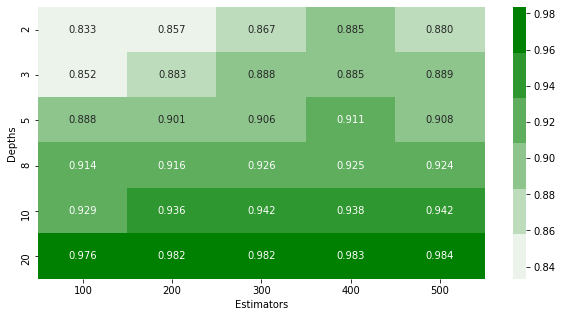

------------------------------ AUC Score for CV data ------------------------------


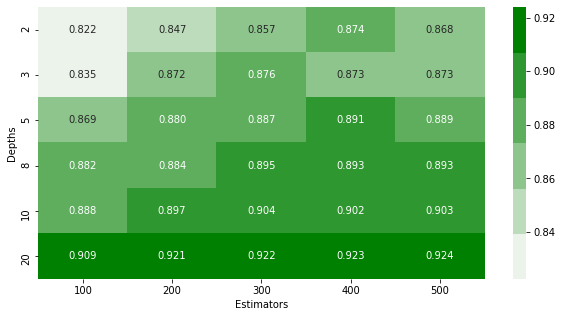

In [36]:
RF_Classifier(bow_train,bow_cv,Y_tr,Y_cv)

### Testing on Test data and Training on BoW for Random Forest

AUC Score for train data 0.9291754147303897
AUC Score for test data 0.8946892072712812
macro f1 score for train data : 0.7910036495601769
macro f1 score for test data : 0.7505347217185727
micro f1 score for train data: 0.8682994923857869
micro f1 score for test data: 0.8439895049368225
hamming loss for train data: 0.1317005076142132
hamming loss for test data: 0.15601049506317752
Precision recall report for train data:
               precision    recall  f1-score   support

           0       0.57      0.79      0.66      6472
           1       0.96      0.88      0.92     32928

    accuracy                           0.87     39400
   macro avg       0.76      0.84      0.79     39400
weighted avg       0.89      0.87      0.88     39400

Precision recall report for test data:
               precision    recall  f1-score   support

           0       0.51      0.72      0.60      4649
           1       0.94      0.87      0.90     24317

    accuracy                           0.84  

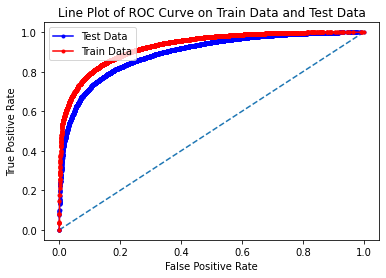

In [44]:
testing(bow_train,Y_tr,bow_test,Y_test,optimal_depth=8,optimal_estimator=400)

### Top 20 Features in BoW for Random Forest 

In [ ]:
clf = RandomForestClassifier(max_depth =10, n_estimators = 400,class_weight='balanced')
clf.fit(bow_train,Y_tr)
features = imp_feature(count_vect,clf)

#Tf-idf

In [50]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tf_idf_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (39400, 640865)
CV Data Size:  (19407, 640865)
Test Data Size:  (28966, 640865)


## Normalizing the data

In [51]:
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
normalizer = preprocessing.Normalizer()
bow_train = normalizer.fit_transform(tfidf_train)
bow_cv = normalizer.transform(tfidf_cv)
bow_test = normalizer.transform(tfidf_test)
print("The shape of out text BOW vectorizer ",tfidf_train.get_shape())
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The shape of out text BOW vectorizer  (39400, 640865)
CV Data Size:  (19407, 640865)
Test Data Size:  (28966, 640865)


### Training Model on TF-IDF for Random Forest 

------------------------------ AUC Score for train data ------------------------------


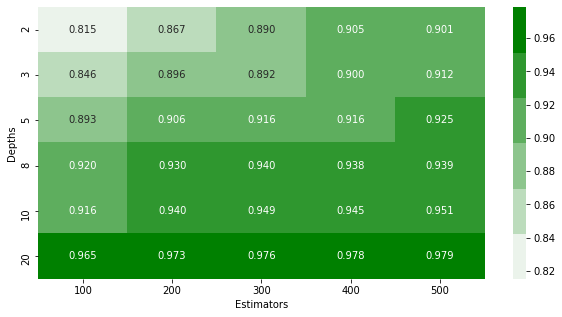

------------------------------ AUC Score for CV data ------------------------------


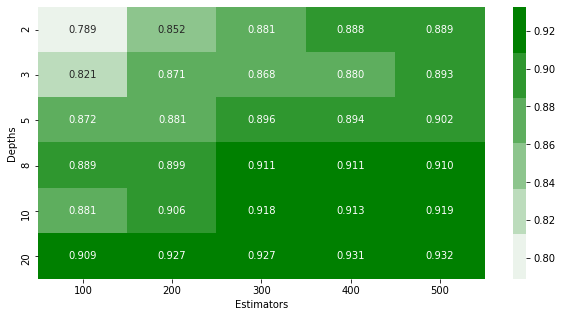

In [52]:
RF_Classifier(tfidf_train,tfidf_cv,Y_tr,Y_cv)

### Testing on Test data and Traing data in TF-IDF for Random Forest

AUC Score for train data 0.9286598899227713
AUC Score for test data 0.9053056100539396
macro f1 score for train data : 0.791224786274635
macro f1 score for test data : 0.7673376466337019
micro f1 score for train data: 0.8688324873096446
micro f1 score for test data: 0.8586964026790029
hamming loss for train data: 0.13116751269035534
hamming loss for test data: 0.14130359732099704
Precision recall report for train data:
               precision    recall  f1-score   support

           0       0.57      0.79      0.66      6472
           1       0.96      0.88      0.92     32928

    accuracy                           0.87     39400
   macro avg       0.76      0.84      0.79     39400
weighted avg       0.89      0.87      0.88     39400

Precision recall report for test data:
               precision    recall  f1-score   support

           0       0.55      0.72      0.62      4649
           1       0.94      0.88      0.91     24317

    accuracy                           0.86  

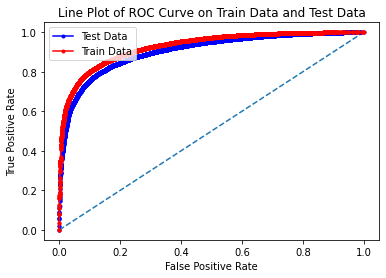

In [53]:
testing(tfidf_train,Y_tr,tfidf_test,Y_test,optimal_depth=5,optimal_estimator=500)

### Top 20 Features in TF-IDF for Random Forest  

In [ ]:
clf = RandomForestClassifier(max_depth =10 , min_samples_split =500, class_weight='balanced')
clf.fit(tfidf_train,Y_tr)
imp_feature(tf_idf_vect,clf)

#Avg-w2v

In [56]:
i=0
list_of_sent_train=[]
for sent in X_tr.values:
    filtered_sentence=[]
    sent=clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)

In [57]:
i=0
list_of_sent_CV=[]
for sent in X_cv.values:
    filtered_sentence=[]
    sent=clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_CV.append(filtered_sentence)

In [58]:
i=0
list_of_sent_test=[]
for sent in X_test.values:
    filtered_sentence=[]
    sent=clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [59]:
import gensim
w2v_model = gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=50,workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [60]:
def avg_w2v(list_of_sent):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)        
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors

In [61]:
train_avgw2v = avg_w2v(list_of_sent_train)
cv_avgw2v = avg_w2v(list_of_sent_CV)
test_avgw2v = avg_w2v(list_of_sent_test)

39400
50
19407
50
28966
50


In [62]:
normalizer = preprocessing.Normalizer()
train_avgw2v = normalizer.fit_transform(train_avgw2v)
cv_avgw2v = normalizer.transform(cv_avgw2v)
test_avgw2v = normalizer.transform(test_avgw2v)

### Training Model on Avg-W2V for Random Forest

------------------------------ AUC Score for train data ------------------------------


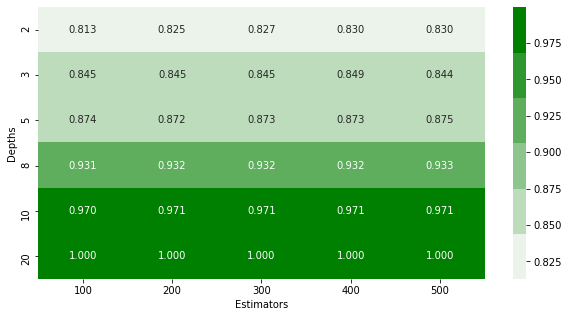

------------------------------ AUC Score for CV data ------------------------------


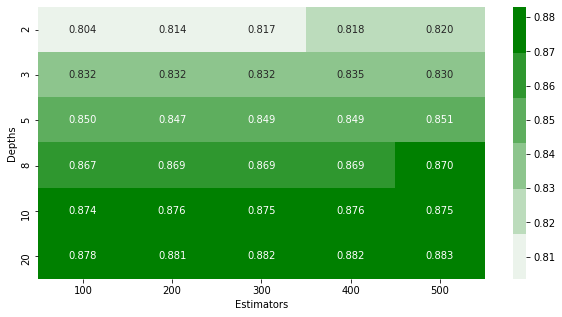

In [63]:
RF_Classifier(train_avgw2v,cv_avgw2v,Y_tr,Y_cv)

### Testing on Test data and Traing data in Avg-W2V for Random Forest

AUC Score for train data 0.8747266904620756
AUC Score for test data 0.8531778841087576
macro f1 score for train data : 0.7113410722926746
macro f1 score for test data : 0.6906622108180578
micro f1 score for train data: 0.7934771573604061
micro f1 score for test data: 0.7799489056134778
hamming loss for train data: 0.20652284263959392
hamming loss for test data: 0.22005109438652212
Precision recall report for train data:
               precision    recall  f1-score   support

           0       0.43      0.79      0.56      6472
           1       0.95      0.79      0.87     32928

    accuracy                           0.79     39400
   macro avg       0.69      0.79      0.71     39400
weighted avg       0.87      0.79      0.81     39400

Precision recall report for test data:
               precision    recall  f1-score   support

           0       0.40      0.76      0.52      4649
           1       0.94      0.78      0.86     24317

    accuracy                           0.78 

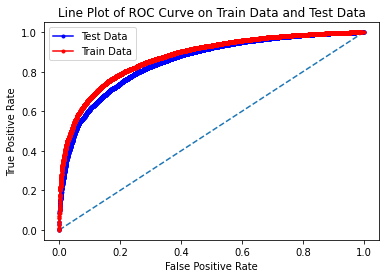

In [64]:
testing(train_avgw2v,Y_tr,test_avgw2v,Y_test,optimal_depth=5,optimal_estimator=500)

#Final Report

In [65]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer","Model","Best Hyper Parameter(Depth)","Best Hyper parameter(n_estimator)","Test Auc Score"]
x.add_row(["BoW","Random Forest",8,400,90.84])
x.add_row(["Tf-Idf","Random Forest",5,500,90.35])
x.add_row(["Avg-W2V","Random Forest",5,500,86.12])
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('****Final Conclusion:****')
print(x)

****Final Conclusion:****

+------------+---------------+-----------------------------+-----------------------------------+----------------+
| Vectorizer |     Model     | Best Hyper Parameter(Depth) | Best Hyper parameter(n_estimator) | Test Auc Score |
+------------+---------------+-----------------------------+-----------------------------------+----------------+
|    BoW     | Random Forest |              8              |                400                |     90.84      |
|   Tf-Idf   | Random Forest |              5              |                500                |     90.35      |
|  Avg-W2V   | Random Forest |              5              |                500                |     86.12      |
+------------+---------------+-----------------------------+-----------------------------------+----------------+
